In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from PIL import Image
import pegasus as pg
import pegasusio as io
import pegasusio
from pegasusio import UnimodalData, MultimodalData
import scipy.stats as st
import squidpy as sq
import seaborn as sns
import os
import glob
from utils.lists import *
from utils.plot_utils import *
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import rc_context
import itertools
import random
import matplotlib.cm
import glob
from collections import Counter, OrderedDict
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import spatialdata as sd
import spatialdata_plot
import spatialdata_io
from spatialdata import bounding_box_query

2024-09-14 19:19:02.483277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 19:19:02.580133: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 19:19:02.583174: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-14 19:19:02.583187: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Fig. 3b snXenium UMAP and Cell proportions

In [2]:
data = sc.read_h5ad('/home/ah2428/girgenti/ah2428/xenium/data_processed_resegment/snXenium.h5ad')

In [3]:
ann = sc.AnnData(data.X)
ann.var_names = data.var_names
ann.obs_names = data.obs_names

In [4]:
ann.obs['celltype'] = data.obs['celltype']
ann.obsm['umap'] = data.obsm['X_umap']

In [5]:
ann.obs.celltype = ann.obs.celltype.cat.reorder_categories(['EXC','INH','OLI','OPC','END','AST','MIC'])

In [6]:
celltype_colors.values()

dict_values(['#b22222', '#2E8B57', '#5254a3', '#aec7e8', '#bc80bd', '#ffed6f', '#7f7f7f'])

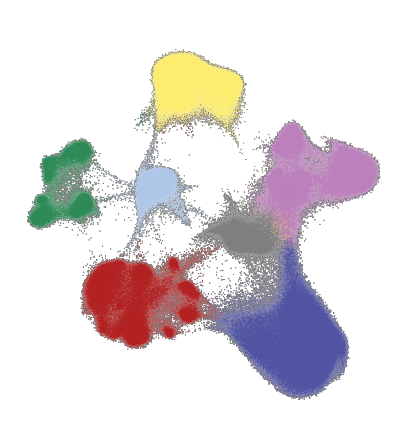

In [10]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(ann, color='celltype', size=1, add_outline=True,palette=list(celltype_colors.values()),save='_xenium.pdf',title=' ',frameon=False,legend_loc=None)

In [8]:
meta = data.obs
arr = np.zeros((3,7))
for ii,cond in enumerate(['CON','MDD','PTSD']):
    x = meta[meta.Condition==cond].celltype.value_counts()/meta[meta.Condition==cond].celltype.value_counts().sum()
    x = x.reindex(['EXC','INH','OLI','OPC','END','AST','MIC'])
    print(x)
    print(x.values)
    arr[ii] = x.values

celltype
EXC    0.180640
INH    0.074925
OLI    0.300696
OPC    0.050428
END    0.190762
AST    0.139514
MIC    0.063036
Name: count, dtype: float64
[0.1806396  0.07492477 0.30069559 0.05042843 0.190762   0.13951407
 0.06303554]
celltype
EXC    0.176406
INH    0.074405
OLI    0.340605
OPC    0.044037
END    0.158005
AST    0.142741
MIC    0.063801
Name: count, dtype: float64
[0.17640612 0.07440476 0.34060451 0.04403693 0.15800542 0.1427413
 0.06380097]
celltype
EXC    0.197361
INH    0.073295
OLI    0.286897
OPC    0.059647
END    0.178111
AST    0.138874
MIC    0.065815
Name: count, dtype: float64
[0.19736097 0.07329473 0.28689731 0.05964687 0.17811062 0.13887422
 0.06581529]


In [9]:
df = pd.DataFrame(arr)
df.index = ['CON','MDD','PTSD']
df.columns = ['EXC','INH','OLI','OPC','END','AST','MIC']
df = df.reindex(['PTSD','MDD','CON'])

In [11]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots()
df.plot(stacked=True,kind='barh',color=list(celltype_colors.values()),figsize=(4,1),width=0.8,legend=None, ax=ax)
ax.set_xlabel('Cell proportion')
ax.set_xticks([0,0.5,1])
ax.set_ylabel(' ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/ah2428/palmer_scratch/figs/fig3/xenium_proportions.pdf',bbox_inches='tight')

In [3]:
np.median(data.obs['n_genes'])

42.0

In [4]:
np.median(data.obs['n_counts'])

87.0

In [5]:
rna_genes = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/data/rna_genes.csv',sep='\t').featurekey.values

In [6]:
xenium_genes = data.var_names

In [7]:
inter = list(set(rna_genes)&set(xenium_genes))

In [8]:
len(inter)

354

In [9]:
354/366

0.9672131147540983

# Fig. 3c snXenium cell types dotplot

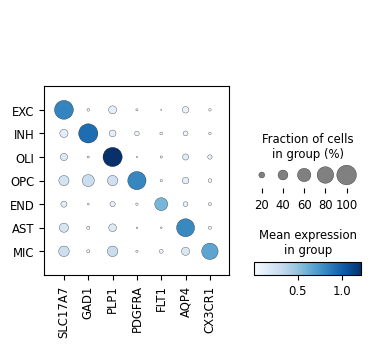

In [6]:
sc.pl.dotplot(data,['SLC17A7','GAD1','PLP1','PDGFRA','FLT1','AQP4','CX3CR1'],groupby='celltype',categories_order=['EXC','INH','OLI','OPC','END','AST','MIC'],cmap='Blues')

# Fig. 3d snXenium MAST DEG results

In [3]:
dfs = []
xenium_ups_n = []
xenium_downs_n = []
xenium_ups = []
xenium_downs = []

condition = 'PTSD'

mast = pd.read_csv(f'/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snXenium/{condition}_vs_CON/MAST_DEG.csv',sep='\t')

for celltype in ['EXC','INH','OLI','OPC','END','AST','MIC']:
    mast_celltype = mast[mast.Celltype==celltype]
    mast_up = mast_celltype[mast_celltype.log2FC > np.log2(1.1)][mast_celltype.FDR < 0.01].Genename.values
    mast_down = mast_celltype[mast_celltype.log2FC < -np.log2(1.1)][mast_celltype.FDR < 0.01].Genename.values
    
    xenium_ups_n.append(len(mast_up))
    xenium_downs_n.append(len(mast_down))
    xenium_ups.append(mast_up)
    xenium_downs.append(mast_down)


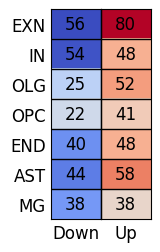

In [4]:
deg_counts_plot(xenium_downs_n,xenium_ups_n,['EXN','IN','OLG','OPC','END','AST','MG'])
plt.savefig('/home/ah2428/palmer_scratch/figs/fig3/deg_counts.png',bbox_inches='tight',dpi=500)

# Fig. 3e snRNA MAST DEG Validation

In [13]:
xenium_genes = pd.read_csv('/home/ah2428/project/PTSD/xenium/xenium_genes.csv',header=None)[0].values

In [14]:
dfs = []
rna_ups_n = []
rna_downs_n = []
rna_ups = []
rna_downs = []

mast = pd.read_csv(f'/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/{condition}_vs_CON/MAST_DEG.csv',sep='\t')

for celltype in ['EXC','INH','OLI','OPC','END','AST','MIC']:
    mast_celltype = mast[mast.Celltype==celltype]
    mast_up = mast_celltype[mast_celltype.log2FC > np.log2(1.2)][mast_celltype.FDR < 0.01].Genename.values
    mast_down = mast_celltype[mast_celltype.log2FC < -np.log2(1.2)][mast_celltype.FDR < 0.01].Genename.values

    inter_up = list(set(mast_up) & set(xenium_genes))
    inter_down = list(set(mast_down) & set(xenium_genes))
    rna_ups.append(inter_up)
    rna_downs.append(inter_down)
    rna_ups_n.append(len(inter_up))
    rna_downs_n.append(len(inter_down))
    

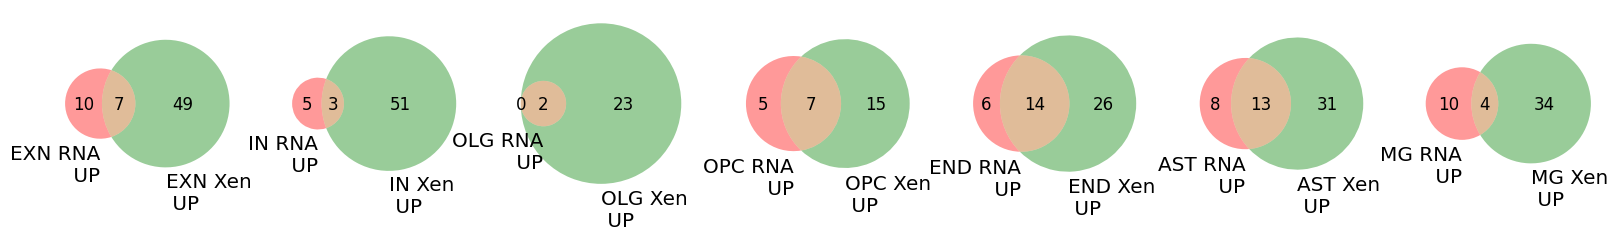

In [15]:
plt.rcParams['font.size']='12'
fig, ax = plt.subplots(1,7,figsize=(20,5))
ax = ax.flatten()
inter_ups = []
inter_up_genes = []
for i,celltype in enumerate(['EXN','IN','OLG','OPC','END','AST','MG']):
    rna_up = rna_ups[i]
    xenium_up = xenium_ups[i]
    overlap = len(list(set(rna_up) & set(xenium_up)))
    inter_ups.append(overlap)
    inter_up_genes.append(list(set(rna_up) & set(xenium_up)))
    venn2(subsets = (len(rna_up)-overlap, len(xenium_up)-overlap, overlap), set_labels = (f'{celltype} RNA\n UP', f'{celltype} Xen\n UP'), ax=ax[i])

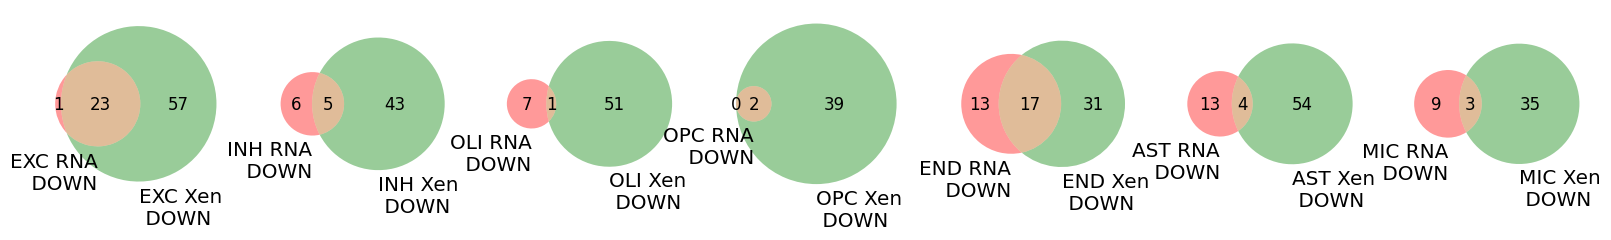

In [16]:
fig, ax = plt.subplots(1,7,figsize=(20,5))
ax = ax.flatten()
inter_downs = []
inter_down_genes = []
for i,celltype in enumerate(['EXC','INH','OLI','OPC','END','AST','MIC']):
    rna_down = rna_downs[i]
    xenium_down = xenium_downs[i]
    overlap = len(list(set(rna_down) & set(xenium_down)))
    inter_downs.append(overlap)
    inter_down_genes.append(list(set(rna_down) & set(xenium_down)))
    venn2(subsets = (len(rna_down)-overlap, len(xenium_down)-overlap, overlap), set_labels = (f'{celltype} RNA\n DOWN', f'{celltype} Xen\n DOWN'), ax=ax[i])

In [19]:
rna_mast = pd.read_csv(f'/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/{condition}_vs_CON/MAST_DEG.csv',sep='\t')
snxenium_mast = pd.read_csv(f'/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snXenium/{condition}_vs_CON/MAST_DEG.csv',sep='\t')
#scxenium_mast = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/scXenium/PTSD_vs_CON/MAST_DEG.csv',sep='\t')

In [20]:
rna_fcs = []
snxenium_fcs = []
for ii,celltype in enumerate(['EXC','INH','OLI','OPC','END','AST','MIC']):
    genes_up = inter_up_genes[ii]
    genes_down = inter_down_genes[ii]
    rna_celltype = rna_mast[rna_mast.Celltype==celltype]
    snxenium_celltype = snxenium_mast[snxenium_mast.Celltype==celltype]
    if len(genes_up) >= 1:
        for g in genes_up:
            #print(g)
            rna_fc = rna_celltype[rna_celltype.Genename==g].log2FC.values[0]
            snxenium_fc = snxenium_celltype[snxenium_celltype.Genename==g].log2FC.values[0]
            rna_fcs.append(rna_fc)
            snxenium_fcs.append(snxenium_fc)
    else:
        pass
    if len(genes_down) >= 1:
        for j in genes_down:
            rna_fc = rna_celltype[rna_celltype.Genename==j].log2FC.values[0]
            snxenium_fc = snxenium_celltype[snxenium_celltype.Genename==j].log2FC.values[0]
            rna_fcs.append(rna_fc)
            snxenium_fcs.append(snxenium_fc)
    else:
        pass

In [25]:
r = [len(x) for x in rna_ups]
df1 = pd.DataFrame(data={'inter':inter_ups,'rna':r})
#df1['rna'] = df1['rna']-df1['inter']

In [26]:
s = [len(x) for x in rna_downs]
df2 = pd.DataFrame(data={'inter':inter_downs,'rna':s})
#df2['rna'] = df2['rna']-df2['inter']

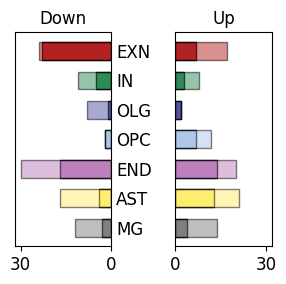

In [27]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = '12'

fig, ax = plt.subplots(1,2, figsize=(3,3))
plt.subplots_adjust(wspace=0)

ax[1].barh(np.arange(7), df1.inter[::-1],color = list(celltype_colors.values())[::-1], height=0.6,edgecolor='k')
ax[1].barh(np.arange(7), df1.rna[::-1],color = list(celltype_colors.values())[::-1], alpha=0.5, height=0.6,edgecolor='k')
ax[1].set_yticks([]) 
ax[1].set_xlim([0,32])
ax[1].set(xticks=[0,30])
ax[1].set_title('Up',fontsize=12)

ax[0].barh(np.arange(7), list(np.array(df2.inter)*-1)[::-1],color = list(celltype_colors.values())[::-1], height=0.6,edgecolor='k')
ax[0].barh(np.arange(7), list(np.array(df2.rna)*-1)[::-1],color = list(celltype_colors.values())[::-1], alpha=0.5, height=0.6,edgecolor='k')
ax[0].set_yticks(np.arange(7))
ax[0].set_yticklabels(celltypes[::-1])
ax[0].yaxis.tick_right()
ax[0].tick_params(axis='y', which=u'both',length=0)
ax[0].set_xlim([-32,0])
ax[0].set(xticks=[0,-30],xticklabels=[0,30])
ax[0].set_title('Down',fontsize=12)

fig.tight_layout()
plt.savefig('/home/ah2428/palmer_scratch/figs/fig3/mast_overlap.pdf',bbox_inches='tight',dpi=500)

In [28]:
(df1.inter.values.sum() + df2.inter.values.sum())/(df1.rna.values.sum() + df2.rna.values.sum())

0.5303030303030303

# Fig. 3f snXenium END PTSD vs CON MAST DEG Volcano plot

(-5.0, 5.0)

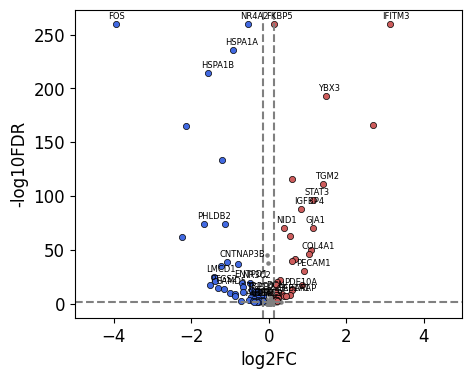

In [29]:
xenium_genes = pd.read_csv('/home/ah2428/project/PTSD/xenium/xenium_genes.csv',header=None)[0].values
rna = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/PTSD_vs_CON/MAST_DEG.csv',sep='\t')
rna = rna[rna.Celltype=='END']
rna = rna[np.abs(rna.log2FC) > np.log2(1.2)][rna.FDR < 0.01]

rna_down = list(set(xenium_genes) & set(rna[rna.log2FC < 0].Genename.unique()))
rna_up = list(set(xenium_genes) & set(rna[rna.log2FC > 0].Genename.unique()))

deg = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snXenium/PTSD_vs_CON/MAST_DEG.csv',sep='\t')

deg = deg[deg.Celltype=='END']

deg.sort_values('FDR')
deg.loc[deg.FDR==0, 'FDR'] = 9.675486e-261

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(x=deg.log2FC,y=deg.FDR.apply(lambda x:-np.log10(x)),s=5,label="Not significant",color='gray')

# highlight down- or up- regulated genes
down = deg[(deg.log2FC < -np.log2(1.1))&(deg.FDR < 0.01)]
up = deg[(deg.log2FC > np.log2(1.1))&(deg.FDR < 0.01)]

plt.scatter(x=down['log2FC'],y=down['FDR'].apply(lambda x:-np.log10(x)),s=20,color='royalblue',edgecolor='black',linewidth=0.5)
plt.scatter(x=up['log2FC'],y=up['FDR'].apply(lambda x:-np.log10(x)),s=20,color='indianred',edgecolor='k',linewidth=0.5)
ups = []
for i in up.Genename.values:
    if i in rna_up:
        ups.append(i)
        x = up[up.Genename==i]
        plt.text(x.log2FC-0.2,-np.log10(x['FDR'])+5,i,fontsize=6)
downs = []
for i in down.Genename.values:
    if i in rna_down:
        downs.append(i)
        x = down[down.Genename==i]
        plt.text(x.log2FC-0.2,-np.log10(x['FDR'])+5,i,fontsize=6)

plt.xlabel("log2FC")
plt.ylabel("-log10FDR")
plt.axvline(-np.log2(1.1),color="grey",linestyle="--")
plt.axvline(np.log2(1.1),color="grey",linestyle="--")
plt.axhline(-np.log10(0.01),color="grey",linestyle="--")
plt.xlim([-5,5])

#plt.savefig('/home/ah2428/palmer_scratch/figs/fig3/volcano.pdf',bbox_inches='tight',dpi=300)

# Fig. 3g FKBP5 PTSD vs CON expression

2024-09-14 19:19:40,984 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.13s.


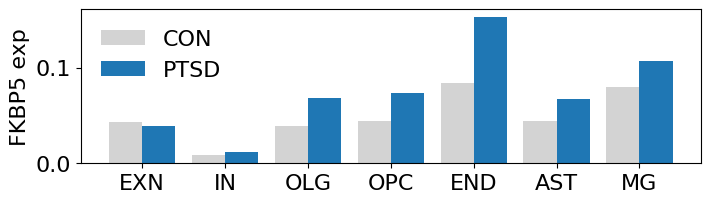

In [3]:
plot_xenium_gene_exp_barplot('FKBP5')

# Fig. 3h FKBP5 CON Slide 

INFO     reading /gpfs/gibbs/pi/girgenti/ah2428/xenium/data/5638_resegment/outs/cell_feature_matrix.h5             


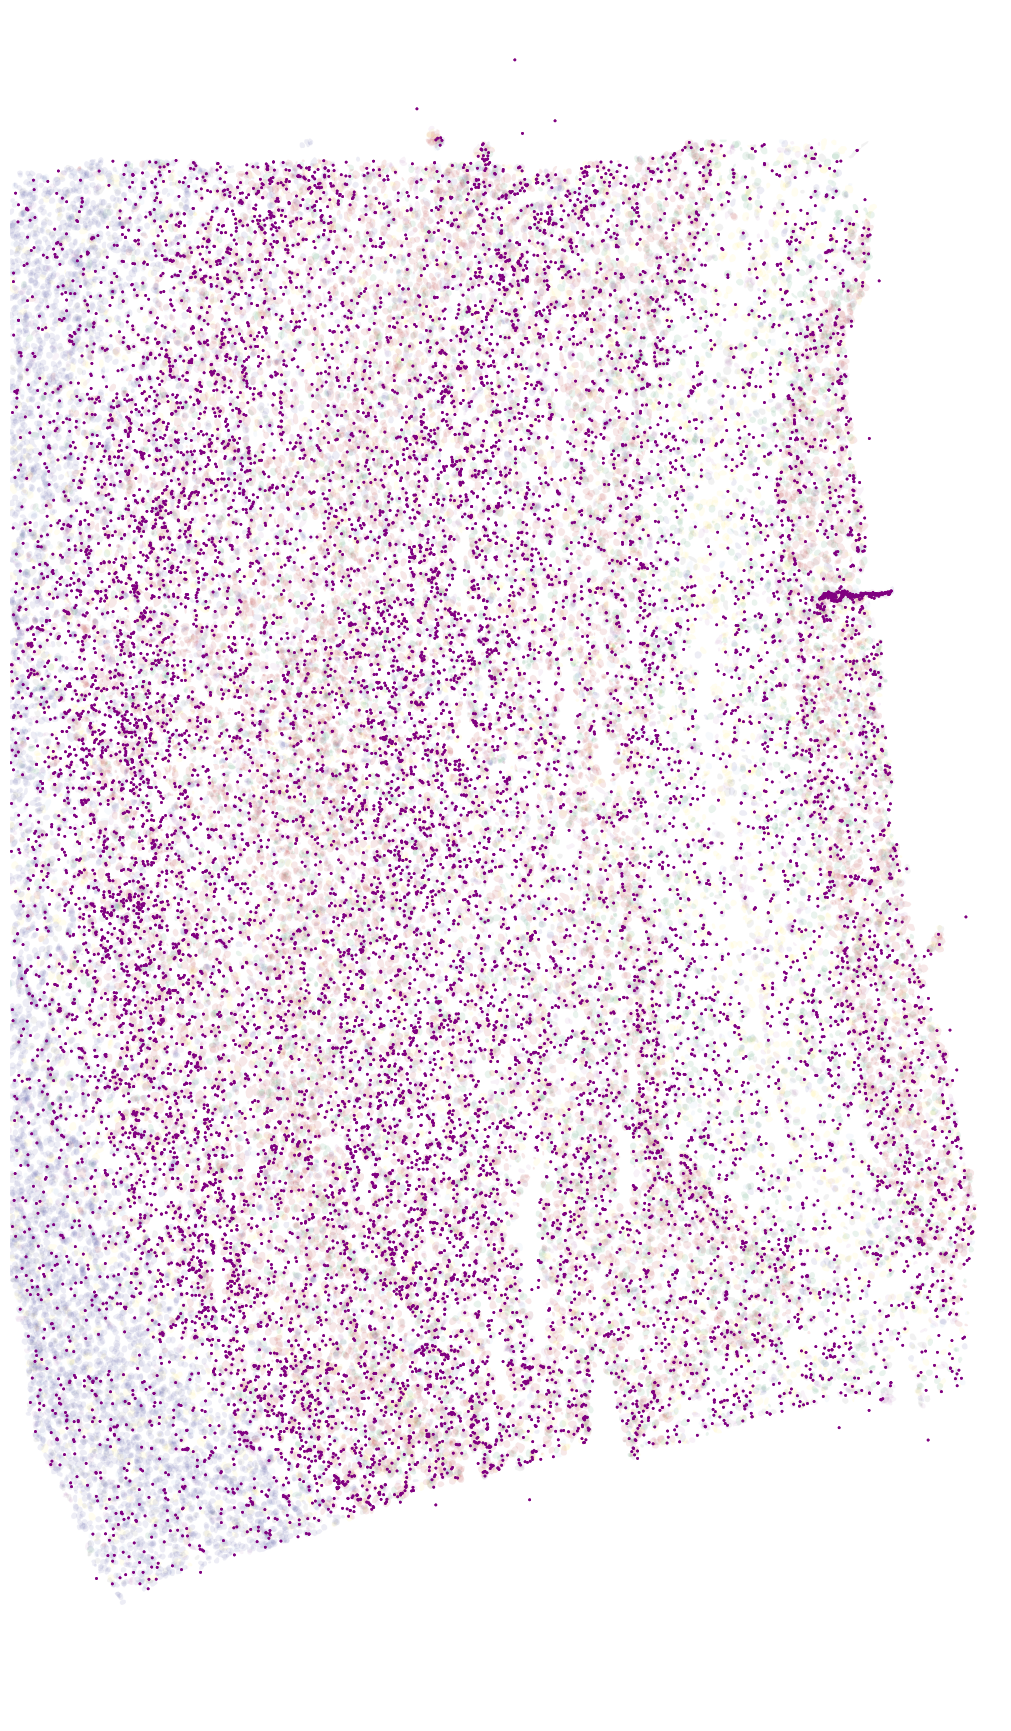

In [37]:
sdata = plot_xenium_slide('5638','KFBP5','purple','/home/ah2428/palmer_scratch/figs/fig3/')

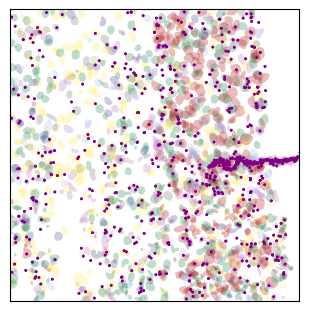

In [40]:
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[16800,12000],
    max_coordinate=[22800,18000],
    axes=("x", "y"),
    target_coordinate_system="global",
)
subset = crop0(sdata)

subset.pl.render_shapes("cell_boundaries",
                       color='celltype',
                       groups=['EXC','INH','OLI','OPC','END','AST','MIC'],
                       palette=['#b22222','#2E8B57','#5254a3','#aec7e8','#bc80bd','#ffed6f','#7f7f7f'],
                       scale=5, 
                       outline=False, 
                       fill_alpha=0.3).pl.render_points('transcripts',color='feature_name',groups='FKBP5',palette='purple',size=1).pl.show(figsize=(3,3))
plt.legend('',frameon=False)
plt.title('')
plt.xticks([])
plt.yticks([])
plt.savefig('/home/ah2428/palmer_scratch/figs/fig3/con_inset.pdf',bbox_inches='tight',dpi=500)

# Fig. 3i FKBP5 PTSD Slide

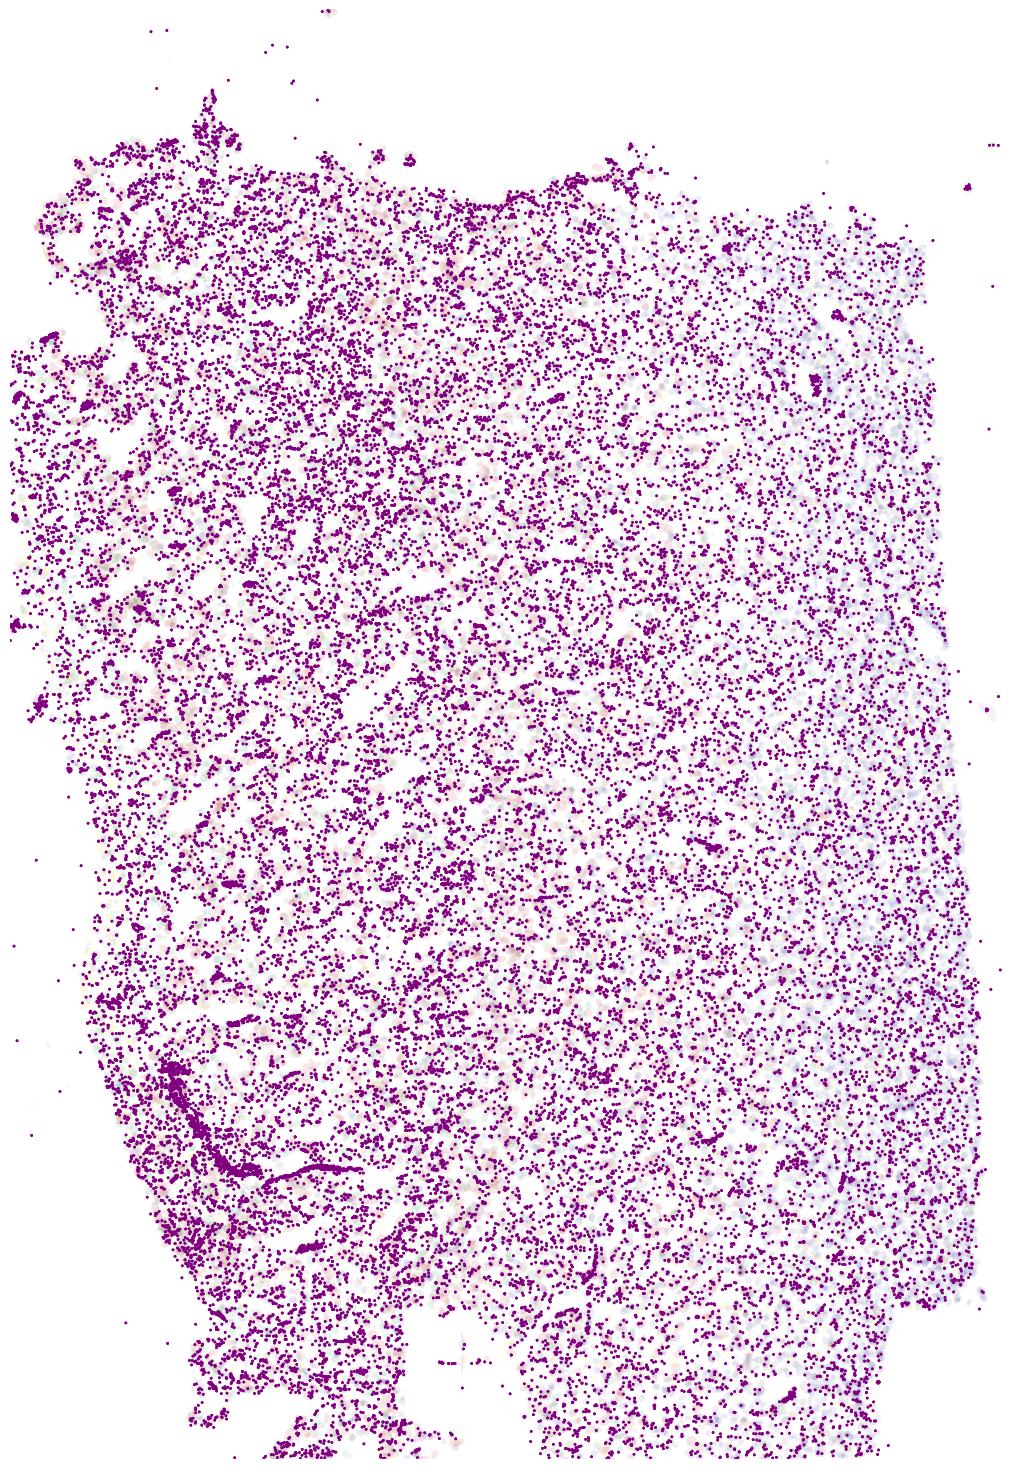

In [36]:
sdata = plot_xenium_slide('5173','KFBP5','purple','/home/ah2428/palmer_scratch/figs/fig3/')

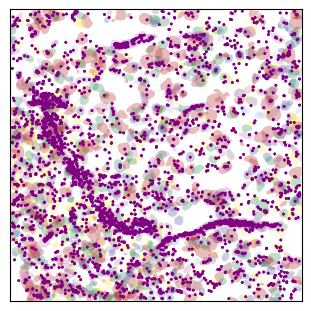

In [25]:
from spatialdata import bounding_box_query

crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[3500,25500],
    max_coordinate=[9500,31500],
    axes=("x", "y"),
    target_coordinate_system="global",
)
subset = crop0(sdata)

subset.pl.render_shapes("cell_boundaries",
                       color='celltype',
                       groups=['EXC','INH','OLI','OPC','END','AST','MIC'],
                       palette=['#b22222','#2E8B57','#5254a3','#aec7e8','#bc80bd','#ffed6f','#7f7f7f'],
                       scale=5, 
                       outline=False, 
                       fill_alpha=0.3).pl.render_points('transcripts',color='feature_name',groups='FKBP5',palette='purple',size=1).pl.show(figsize=(3,3))
plt.legend('',frameon=False)
plt.title('')
plt.xticks([])
plt.yticks([])
plt.savefig('/home/ah2428/palmer_scratch/figs/fig3/fkbp5_inset.pdf',bbox_inches='tight',dpi=500)
plt.show()

In [57]:
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[3500,25500],
    max_coordinate=[9500,31500],
    axes=("x", "y"),
    target_coordinate_system="global",
)
subset = crop0(sdata)

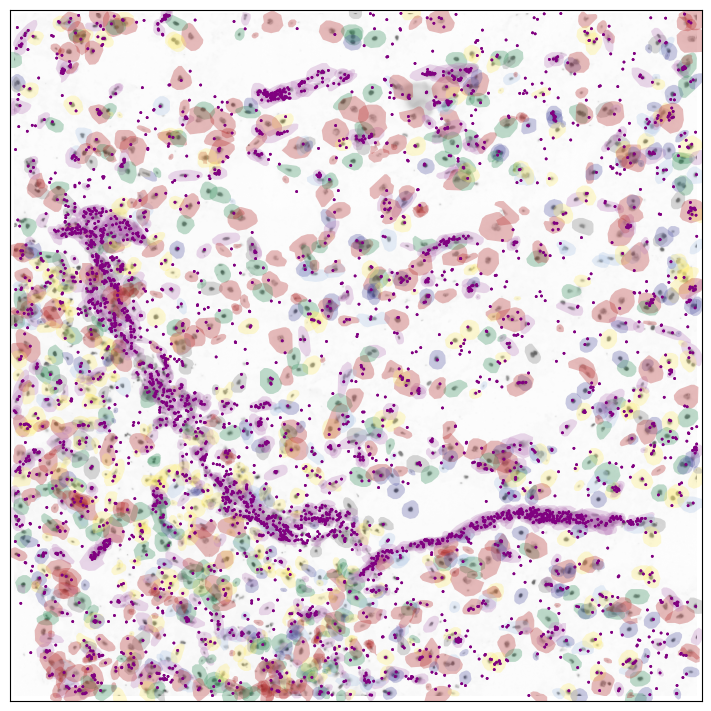

In [63]:
# Overlaying morphology image

subset.pl.render_images("morphology_focus",cmap='Grays',dpi=300,norm=colors.PowerNorm(gamma=0.5)).pl.render_shapes("cell_boundaries",
                       color='celltype',
                       groups=['EXC','INH','OLI','OPC','END','AST','MIC'],
                       palette=['#b22222','#2E8B57','#5254a3','#aec7e8','#bc80bd','#ffed6f','#7f7f7f'],
                       scale=4, 
                       outline=False, 
                       fill_alpha=0.3).pl.render_points('transcripts',color='feature_name',groups='FKBP5',palette='purple',size=1).pl.show(figsize=(7,7))
plt.title('')
plt.legend('',frameon=False)
plt.title('')
plt.xticks([])
plt.yticks([])
plt.show()

# Fig. 3a Visualization icon 

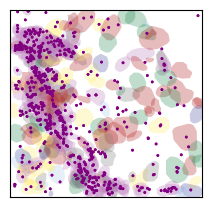

In [93]:
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[4000,27000],
    max_coordinate=[6000,29000],
    axes=("x", "y"),
    target_coordinate_system="global",
)
subset = crop0(sdata)

subset.pl.render_shapes("cell_boundaries",
                       color='celltype',
                       groups=['EXC','INH','OLI','OPC','END','AST','MIC'],
                       palette=['#b22222','#2E8B57','#5254a3','#aec7e8','#bc80bd','#ffed6f','#7f7f7f'],
                       scale=5, 
                       outline=False, 
                       fill_alpha=0.3).pl.render_points('transcripts',color='feature_name',groups='FKBP5',palette='purple',size=1).pl.show(figsize=(3,3))
plt.legend('',frameon=False)
plt.title('')
plt.xticks([])
plt.yticks([])
plt.savefig('/home/ah2428/palmer_scratch/figs/fig3/xenium_icon.pdf',bbox_inches='tight',dpi=1000)
plt.show()